In [ ]:
%reload_ext autoreload

%autoreload 2

import pandas as pd
import numpy as np
import yfinance as yf
pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:.2f}'.format
import requests_cache
from tools import my_stocks
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-agent'] = 'my-program/1.0'

start_date = pd.to_datetime("2019-01-01")
# end_date = pd.to_datetime("2023-12-31")
end_date = None


stock_symbols = my_stocks()
# stock_data = yf.download(stock_symbols, start=start_date, end=end_date, session=session)

In [ ]:
class PortfolioBacktester:
    """
    A class for backtesting a portfolio with quarterly changing weights and calculating risk metrics.
    """
    
    def __init__(self, start_date, end_date, stock_symbols, risk_free_rate=0, initial_investment=1000000, reset_model=False, ):
        """
        Initializes the PortfolioBacktester class.

        Args:
            prices: A pandas DataFrame with dates (index) and stock prices as columns.
            weights: A pandas DataFrame with dates (index) and weights for each stock as columns.
            risk_free_rate: Risk-free rate of return (default: 0).
        """
        self.reset_model = reset_model
        self.initial_investment = initial_investment
        self.main_result = pd.DataFrame()
        
        stock_data = yf.download(stock_symbols, start=start_date, end=end_date, session=session)
        stock_data = stock_data[:]["Adj Close"]
        stock_data.dropna(how='any', inplace=True)

        self.prices = stock_data
        self.risk_free_rate = risk_free_rate

    def load_weights(self, weights):
        self.weights = weights

    def _validate_data(self):
        """
        Performs data validation (date format, quarterly weights).
        """
        # self.prices.index = pd.to_datetime(self.prices.index)
        # self.weights.index = pd.to_datetime(self.weights.index)

        # if len(self.weights.resample("Q").size()) != len(self.weights):
        #     raise ValueError("Weights must change quarterly")

    def backtest(self, start_date, end_date):
        """
        Backtests the portfolio for the specified period and calculates performance metricsel.s.

        Args:
            start_date: Start date for backtesting (string in YYYY-MM-DD format).
            end_date: End date for backtesting (string in YYYY-MM-DD format).

        Returns:
            A pandas DataFrame with portfolio performance metrics.
        """
        # Filter data for backtesting period
        prices_filtered = self.prices.loc[start_date:end_date]
        weights_filtered = self.weights.loc[start_date:end_date]

        # Daily portfolio value
        portfolio_value = (prices_filtered * weights_filtered).sum(axis=1)
        # portfolio_value.dropna(how="any", inplace=True)
        # print(portfolio_value)
        # Daily returns
        daily_returns = portfolio_value.pct_change()
        daily_returns[0] = 0
        
        investment_Value = (daily_returns.cumsum()+ 1)*1000000
        

        # Expected Return (annualized)
        expected_return = daily_returns.mean() * 252


        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252)

        # Max Drawdown
        max_drawdown = (portfolio_value / portfolio_value.cummax()).min() -1
        # max_drawdown = 1 - (portfolio_value / portfolio_value.cummin()).min()

        # Sharpe Ratio
        sharpe_ratio = (expected_return - self.risk_free_rate) / volatility

        # Calculate CAGR
        start_value = portfolio_value.iloc[0]
        end_value = portfolio_value.iloc[-1]
        num_years = len(portfolio_value) / 252  # Assuming 252 trading days in a year
        cagr = (end_value / start_value) ** (1 / num_years) - 1

        # Print CAGR

        # Sortino Ratio (assuming negative returns for downside deviation)
        downside_returns = daily_returns[daily_returns < 0]
        sortino_ratio = (
            (expected_return - self.risk_free_rate)
            / downside_returns.std()
            * np.sqrt(252)
        )

        # Omega Ratio (assuming positive returns for upside potential)
        upside_returns = daily_returns[daily_returns > 0]
        omega_ratio = (
            upside_returns.mean() / abs(downside_returns.mean()) * np.sqrt(252)
        )

        # Combine results
        results = pd.DataFrame(
            {
                "Portfolio Unit Value": portfolio_value,
                "Daily Return": daily_returns,
                "Investment Value": investment_Value,
                "Expected Return": expected_return,
                "Volatility": volatility,
                "Max Drawdown": max_drawdown,
                "Sharpe Ratio": sharpe_ratio,
                "Sortino Ratio": sortino_ratio,
                "Omega Ratio": omega_ratio,
                "CAGR": cagr
            }
        )
        if self.reset_model:
            self.main_result = results
        else:
            self.main_result = pd.concat([self.main_result, results])
            
    def final_output(self):
        return self.main_result

In [ ]:
class PortfolioOptimizer(PortfolioBacktester):
    def __init__(self, start_date, end_date, stock_symbols, risk_free_rate=0, reset_model=False):
        
        super().__init__(start_date, end_date, stock_symbols, risk_free_rate, reset_model, )
        self.stocks_prices = self.prices

        
    def equal_weighted(self):   
        weights = pd.DataFrame(1 / len(stock_symbols), index=self.stocks_prices.index, columns=stock_symbols)
        self.load_weights(weights)
        self.backtest(start_date, end_date)
        return self.final_output()
    
    # Maximum Diversification Portfolio Optimization
    def max_diversification(self):

        import riskfolio as rp

        def q_rebal(daily_returns):
            

# Building the portfolio object
            port = rp.Portfolio(returns=daily_returns)

            port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
            # Estimate optimal portfolio:
            port.mu = pd.DataFrame(
                np.sqrt(np.diag(port.cov)).reshape(-1, len(daily_returns.columns)), columns=daily_returns.columns)

            w1 = port.optimization(model='Classic', rm='MV',
                                obj='Sharpe', rf=0, l=0, hist=True)
            # Estimate points in the efficient frontier mean - semi standard deviation

            # Estimate the risk parity portfolio for semi standard deviation
            weights = w1.T

            

            return weights
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = q_rebal(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()

    # Risk Parity Portfolio Optimisation
    def min_risk(self):

        import riskfolio as rp
        def q_rebal(daily_returns):

            port = rp.Portfolio(returns=daily_returns)

            port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
            w = port.optimization(model='Classic',obj='MinRisk', rm='MV', rf=0, hist=True)

            weights = w
            return weights
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = q_rebal(i)
            w = pd.DataFrame(w).T
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()


    # Mean Variance Portfolio Optimisation
    def mean_variance(self):

        import riskfolio as rp
        
        def q_rebal(daily_returns):
            port = rp.Portfolio(returns=daily_returns)
            port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
            w1 = port.optimization(model='Classic', rm='MV',
                       obj='Sharpe', rf=0, l=0, hist=True)
            return w1
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = q_rebal(i)
            w = pd.DataFrame(w).T
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()

    # Mean-Absolute Deviation Portfolio Optimisation
    def MAD(self):

        import riskfolio as rp

        def q_rebal(daily_returns):

            port = rp.Portfolio(returns=daily_returns)

            port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
            w = port.optimization(model='Classic', rm='MAD', rf=0, hist=True)

            weights = w
            return weights
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = q_rebal(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w = pd.DataFrame(w).T
            
            # print(w)
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()


    # Minimax Portfolio Optimisation
    def minimax(self):

        import riskfolio as rp

        def q_rebal(daily_returns):

            port = rp.Portfolio(returns=daily_returns)

            port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
            w = port.optimization(model='Classic', rm='WR', rf=0, hist=True)

            weights = w
            return weights
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = q_rebal(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w = pd.DataFrame(w).T
            
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()

    # Lower partial moment Portfolio Optimisation
    def lower_partial_moment(self):

        import riskfolio as rp

        def q_rebal(daily_returns):

            port = rp.Portfolio(returns=daily_returns)

            port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
            w = port.optimization(model='Classic', rm='SLPM', rf=0, hist=True)

            weights = w
            return weights
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = q_rebal(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w = pd.DataFrame(w).T
            
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()

In [ ]:
# p = PortfolioOptimizer(stock_symbols=stock_symbols, reset_model=True)
# res1 = p.equal_weighted()
# res = p.mean_variance()
# res3 = p.max_diversification()
# res = p.minimax()
# res = p.risk_parity()
# res = p.lower_partial_moment()


# p = PortfolioOptimizer(stock_symbols=stock_symbols, reset_model=True)
# display(res)

In [ ]:
# plt = res["Investment Value"]
# plt.plot()




In [ ]:
# p.weights

In [ ]:
class PortfolioOptimizer_ML(PortfolioOptimizer):
    def __init__(self, start_date, end_date, stock_symbols, risk_free_rate=0, reset_model=False,):
        
        super().__init__(start_date, end_date, stock_symbols, risk_free_rate, reset_model, )
        self.stocks_prices = self.prices
        
    def RF(self):
        import numpy as np
        from sklearn.ensemble import RandomForestRegressor

        def portfolio_optimization(returns, target_return=self.risk_free_rate):
            # Convert returns to a numpy array
            returns = np.array(returns)
            
            # Compute mean returns and covariance matrix
            mean_returns = np.mean(returns, axis=0)
            cov_matrix = np.cov(returns.T)
            
            # Create a dataset of random portfolios
            num_portfolios = 10000
            portfolios = np.random.uniform(0, 1, (num_portfolios, len(mean_returns)))
            portfolios = portfolios / np.sum(portfolios, axis=1)[:, np.newaxis]
            
            # Compute returns and volatilities for each portfolio
            portfolio_returns = np.dot(portfolios, mean_returns)
            portfolio_volatilities = []
            for portfolio in portfolios:
                portfolio_volatility = np.sqrt(np.dot(portfolio, np.dot(cov_matrix, portfolio)))
                portfolio_volatilities.append(portfolio_volatility)
            portfolio_volatilities = np.array(portfolio_volatilities)
            
            # Compute Sharpe ratios
            sharpe_ratios = (portfolio_returns - target_return) / portfolio_volatilities
            
            # Train the Random Forest model
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(portfolios, sharpe_ratios)
            
            # Optimize the portfolio weights
            max_sharpe_weight = rf.predict(np.eye(len(mean_returns)))
            max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)
            
            # Ensure weights are between 0 and 1
            max_sharpe_weight = np.clip(max_sharpe_weight, 0, 1)
            
            # Normalize weights to sum up to 1
            max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)
            
            return max_sharpe_weight
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = portfolio_optimization(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w = pd.DataFrame(w, index=daily_returns.columns).T
            
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            # display(w)
            
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()
    
    def SVM(self):
        import numpy as np
        from sklearn.svm import SVR

        def portfolio_optimization(returns, target_return = self.risk_free_rate):
            # Convert returns to a numpy array
            returns = np.array(returns)
            
            # Compute mean returns and covariance matrix
            mean_returns = np.mean(returns, axis=0)
            cov_matrix = np.cov(returns.T)
            
            # Create a dataset of random portfolios
            num_portfolios = 10000
            portfolios = np.random.uniform(0, 1, (num_portfolios, len(mean_returns)))
            portfolios = portfolios / np.sum(portfolios, axis=1)[:, np.newaxis]
            
            # Compute returns and volatilities for each portfolio
            portfolio_returns = np.dot(portfolios, mean_returns)
            portfolio_volatilities = []
            for portfolio in portfolios:
                portfolio_volatility = np.sqrt(np.dot(portfolio, np.dot(cov_matrix, portfolio)))
                portfolio_volatilities.append(portfolio_volatility)
            portfolio_volatilities = np.array(portfolio_volatilities)
            
            # Compute Sharpe ratios
            sharpe_ratios = (portfolio_returns - target_return) / portfolio_volatilities
            
            # Train the SVR model
            svr = SVR(kernel='rbf', C=1000, epsilon=0.01)
            svr.fit(portfolios, sharpe_ratios)
            
            # Optimize the portfolio weights
            max_sharpe_weight = svr.predict(np.eye(len(mean_returns)))
            max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)
            
            # Ensure weights are between 0 and 1
            max_sharpe_weight = np.clip(max_sharpe_weight, 0, 1)
            
            # Normalize weights to sum up to 1
            max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)
            
            return max_sharpe_weight
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = portfolio_optimization(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w = pd.DataFrame(w, index=daily_returns.columns).T
            
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            # display(w)
            
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()
    
    def MVF(self):
        import numpy as np
        import cvxopt as cv
        def portfolio_optimization(returns, target_return=self.risk_free_rate, forecast_returns=None):
    # Convert returns to a numpy array
            returns = np.array(returns)

            # Compute mean returns and covariance matrix
            mean_returns = np.mean(returns, axis=0)
            cov_matrix = np.cov(returns.T)

            # If forecast returns are provided, use them instead of historical returns
            if forecast_returns is not None:
                mean_returns = forecast_returns

            # Solve the optimization problem using quadratic programming
            num_assets = len(mean_returns)
            P = cv.matrix(cov_matrix.tolist())
            q = cv.matrix(np.zeros((num_assets, 1)))
            G = cv.matrix(np.vstack((np.eye(num_assets), -np.eye(num_assets))).tolist()).trans()
            # G = G.astype(float)
            h = cv.matrix(np.ones((2 * num_assets, 1)))
            A = cv.matrix(np.ones((1, num_assets)))
            b = cv.matrix(1.0)
            print(G.size)

            # Solve the optimization problem
            sol = cv.solvers.qp(P, q, G, h, A, b)
            if sol['status'] != 'optimal':
                raise ValueError('Optimization problem could not be solved')

            # Get the optimal portfolio weights
            optimal_weights = np.array(sol['x']).flatten()

            # Ensure weights are between 0 and 1
            optimal_weights = np.clip(optimal_weights, 0, 1)

            # Normalize weights to sum up to 1
            optimal_weights = optimal_weights / np.sum(optimal_weights)

            return optimal_weights
                
        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")
        
        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = portfolio_optimization(i)
            # w = pd.DataFrame.from_dict(w, orient='index', columns=['Weight'],).T
            w = pd.DataFrame(w, index=daily_returns.columns).T
            
            w.index = pd.to_datetime([name])
            # print(i.index[-1])
            display(w)
            
            Weights = pd.concat([Weights, w])
            Weights = Weights.drop_duplicates().reindex(self.prices.index)

            Weights = Weights.ffill()
            Weights = Weights.bfill()
            
        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
        raise NotImplementedError()



In [ ]:
# p = PortfolioOptimizer_ML(stock_symbols, reset_model=True)
# p.SVM()

In [ ]:
class PortfolioOptimizer_DL(PortfolioOptimizer_ML):
    def __init__(self, start_date, end_date, stock_symbols, risk_free_rate=0, reset_model=False, ):
    
        super().__init__(start_date, end_date, stock_symbols, risk_free_rate, reset_model)
        self.stocks_prices = self.prices
        
    def DMLP(self):
        import numpy as np
        import pandas as pd
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping
        
        
        mlp_model = Sequential()
        mlp_model.add(Dense(64, activation='relu'))
        mlp_model.add(Dense(32, activation='relu'))
        mlp_model.add(Dense(1, activation='linear'))
        mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        # mlp_model.fit(portfolios, sharpe_ratios, epochs=100, batch_size=32, verbose=0)
        
                    # Define early stopping callback
        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        
        def portfolio_optimization(returns, target_return=self.risk_free_rate):
            # Convert returns to a numpy array
            returns = np.array(returns)

            # Compute mean returns and covariance matrix
            mean_returns = np.mean(returns, axis=0)
            cov_matrix = np.cov(returns.T)

            # Create a dataset of random portfolios
            num_portfolios = 100000
            portfolios = np.random.uniform(0, 1, (num_portfolios, len(mean_returns)))
            portfolios = portfolios / np.sum(portfolios, axis=1)[:, np.newaxis]

            # Compute returns and volatilities for each portfolio
            portfolio_returns = np.dot(portfolios, mean_returns)
            portfolio_volatilities = []
            for portfolio in portfolios:
                portfolio_volatility = np.sqrt(np.dot(portfolio, np.dot(cov_matrix, portfolio)))
                portfolio_volatilities.append(portfolio_volatility)
            portfolio_volatilities = np.array(portfolio_volatilities)

            # Compute Sharpe ratios
            sharpe_ratios = (portfolio_returns - target_return) / portfolio_volatilities

            # Train the MLP model
            

            # Fit the MLP model with early stopping
            mlp_model.fit(portfolios, sharpe_ratios, epochs=1000, batch_size=32, verbose=0, callbacks=[early_stopping])

            # Optimize the portfolio weights
            max_sharpe_weight = mlp_model.predict(np.eye(len(mean_returns)))
            max_sharpe_weight = max_sharpe_weight.flatten()

            # Ensure weights are between 0 and 1
            max_sharpe_weight = np.clip(max_sharpe_weight, 0, 1)

            # Normalize weights to sum up to 1
            max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)

            return max_sharpe_weight

        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")

        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = portfolio_optimization(i)
            w = pd.DataFrame(w, index=daily_returns.columns).T
            w.index = pd.to_datetime([name])
            display(w)
            Weights = pd.concat([Weights, w])

        Weights = Weights.drop_duplicates().reindex(self.prices.index)
        Weights = Weights.ffill()
        Weights = Weights.bfill()

        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()
    


    def DLSTM(self):
        import numpy as np
        import pandas as pd
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping
        def portfolio_optimization(returns, target_return=self.risk_free_rate):
            # Convert returns to a numpy array
            returns = np.array(returns)

            # Compute mean returns and covariance matrix
            mean_returns = np.mean(returns, axis=0)
            cov_matrix = np.cov(returns.T)

            # Create a dataset of random portfolios
            num_portfolios = 10000
            portfolios = np.random.uniform(0, 1, (num_portfolios, len(mean_returns)))
            portfolios = portfolios / np.sum(portfolios, axis=1)[:, np.newaxis]

            # Compute returns and volatilities for each portfolio
            portfolio_returns = np.dot(portfolios, mean_returns)
            portfolio_volatilities = []
            for portfolio in portfolios:
                portfolio_volatility = np.sqrt(np.dot(portfolio, np.dot(cov_matrix, portfolio)))
                portfolio_volatilities.append(portfolio_volatility)
            portfolio_volatilities = np.array(portfolio_volatilities)

            # Compute Sharpe ratios
            sharpe_ratios = (portfolio_returns - target_return) / portfolio_volatilities

            # Prepare data for LSTM
            X = np.expand_dims(portfolios, axis=2)
            y = sharpe_ratios

            # Define LSTM model
            lstm_model = Sequential()
            lstm_model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
            lstm_model.add(Dense(64, activation='relu'))
            lstm_model.add(Dense(32, activation='relu'))
            lstm_model.add(Dense(1, activation='linear'))
            lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

            # Define early stopping callback
            early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

            # Fit the LSTM model with early stopping
            lstm_model.fit(X, y, epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])

            # Optimize the portfolio weights
            max_sharpe_weight = lstm_model.predict(np.eye(len(mean_returns)).reshape(-1, len(mean_returns), 1))
            max_sharpe_weight = max_sharpe_weight.flatten()

            # Ensure weights are between 0 and 1
            max_sharpe_weight = np.clip(max_sharpe_weight, 0, 1)

            # Normalize weights to sum up to 1
            max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)

            return max_sharpe_weight

        daily_returns = self.prices.pct_change(fill_method=None)

        Weights = pd.DataFrame()

        weights_df = daily_returns.resample("QE")

        for name, group in weights_df:
            i = daily_returns[:group.index[-1]]
            i.fillna(0, inplace=True)
            w = portfolio_optimization(i)
            w = pd.DataFrame(w, index=daily_returns.columns).T
            w.index = pd.to_datetime([name])
            # display(w)
            Weights = pd.concat([Weights, w])

        Weights = Weights.drop_duplicates().reindex(self.prices.index)
        Weights = Weights.ffill()
        Weights = Weights.bfill()

        self.load_weights(Weights)
        self.backtest(start_date, end_date)
        return self.final_output()

In [ ]:
p = PortfolioOptimizer_DL(stock_symbols=stock_symbols, reset_model=True, start_date=start_date, end_date=end_date)

opt = [p]*12

In [12]:

res0 = opt[0].equal_weighted()
res0.to_pickle("Equal Weighted")

res1 = opt[1].max_diversification()
res1.to_pickle("max_diversification")

res2 = opt[2].min_risk()
res2.to_pickle("min_risk")

res3 = opt[3].mean_variance()
res3.to_pickle("mean_variance")

res4 = opt[4].MAD()
res4.to_pickle("MAD")

res5 = opt[5].minimax()
res5.to_pickle("minimax")

res6 = opt[6].lower_partial_moment()
res6.to_pickle("lower_partial_moment")

res7 = opt[7].RF()
res7.to_pickle("RF")

res8 = opt[8].SVM()
res8.to_pickle("SVM")

res9 = opt[9].MVF()
res9.to_pickle("MVF")

res10 = opt[10].DMLP()
res10.to_pickle("DMLP")

res11 = opt[11].DLSTM()
res11.to_pickle("DLSTM")

# # res = p.mean_variance()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/stepWARNING:tensorflow:5 out of the last 47 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7b8fbd8d4670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


/tmp/ipykernel_4057/336315855.py:152: RuntimeWarning: invalid value encountered in divide
  max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)
/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


/tmp/ipykernel_4057/336315855.py:152: RuntimeWarning: invalid value encountered in divide
  max_sharpe_weight = max_sharpe_weight / np.sum(max_sharpe_weight)
/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


/tmp/ipykernel_4057/879327073.py:60: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  daily_returns[0] = 0


In [21]:
dataframes = [res0, res1, res2, res3, res4, res5, res6, res7, res8, res9, res10, res11 ]


In [99]:
res4

,Portfolio Unit Value,Daily Return,Investment Value,Expected Return,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Omega Ratio,CAGR
Date,,,,,,,,,,
2019-01-01,545.43,0.00,1000000.00,0.21,0.18,-0.34,1.18,352.96,14.67,0.21
2019-01-02,536.10,-0.02,982898.02,0.21,0.18,-0.34,1.18,352.96,14.67,0.21
2019-01-03,530.62,-0.01,972666.96,0.21,0.18,-0.34,1.18,352.96,14.67,0.21
2019-01-04,534.12,0.01,979267.58,0.21,0.18,-0.34,1.18,352.96,14.67,0.21
2019-01-07,533.35,-0.00,977814.25,0.21,0.18,-0.34,1.18,352.96,14.67,0.21
...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2522.15,0.00,2983965.00,0.38,0.54,-0.57,0.71,256.16,17.03,0.28
2024-05-02,2537.12,0.01,2989903.13,0.38,0.54,-0.57,0.71,256.16,17.03,0.28
2024-05-03,2544.95,0.00,2992987.36,0.38,0.54,-0.57,0.71,256.16,17.03,0.28


In [98]:
res11.to_excel("tmp.xlsx")

In [107]:
import pandas as pd

column_name = "Investment Value"
main_df = {
    "Equal Weighted" : res11[column_name],
    "Max Diversification" : res1[column_name],
    "Min Risk" : res2[column_name],
    "Mean Variance" : res3[column_name],
    "MAD" : res4[column_name],
    "Minimax" : res5[column_name],
    "Lower Partial Movement" : res6[column_name],
    "RF" : res7[column_name],
    "SVM" : res8[column_name],
    "MVF" : res9[column_name],
    "DMLP" : res10[column_name],
    "DLSTM" : res11[column_name],
}

display(res11.iloc[1318*2:1318*3])

# Assuming your DataFrame is named 'df'
index_value = '2019-01-01'




,Portfolio Unit Value,Daily Return,Investment Value,Expected Return,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Omega Ratio,CAGR
Date,,,,,,,,,,
2019-01-01,654.72,0.00,1000000.00,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
2019-01-02,651.73,-0.00,995436.09,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
2019-01-03,649.67,-0.00,992271.83,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
2019-01-04,650.50,0.00,993552.41,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
2019-01-07,650.39,-0.00,993382.09,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2018.11,-0.01,2238323.91,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
2024-05-02,2024.99,0.00,2241733.64,0.24,0.21,-0.24,1.15,367.38,17.83,0.24
2024-05-03,2026.46,0.00,2242461.10,0.24,0.21,-0.24,1.15,367.38,17.83,0.24


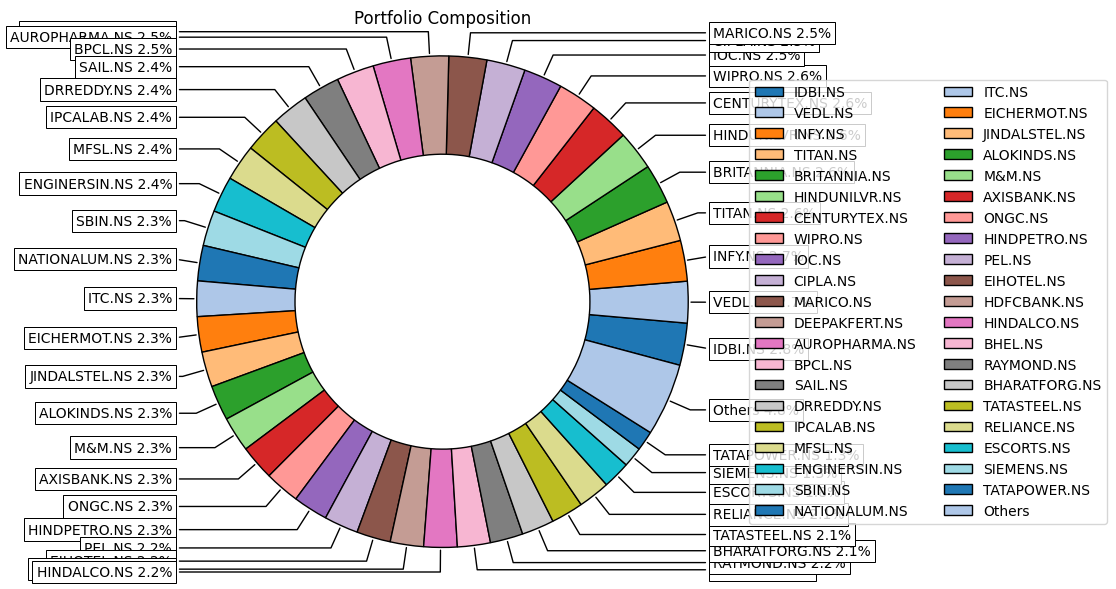

In [56]:
import riskfolio as rp

ax = rp.plot_pie(w=pd.DataFrame(p.weights.iloc[-1]), others=0.05, nrow=25, cmap = "tab20", height=6, width=10, ax=None)
ax.figure.savefig('Images/Weights.png', format='png')

# Save the plot to a file
# ax\)


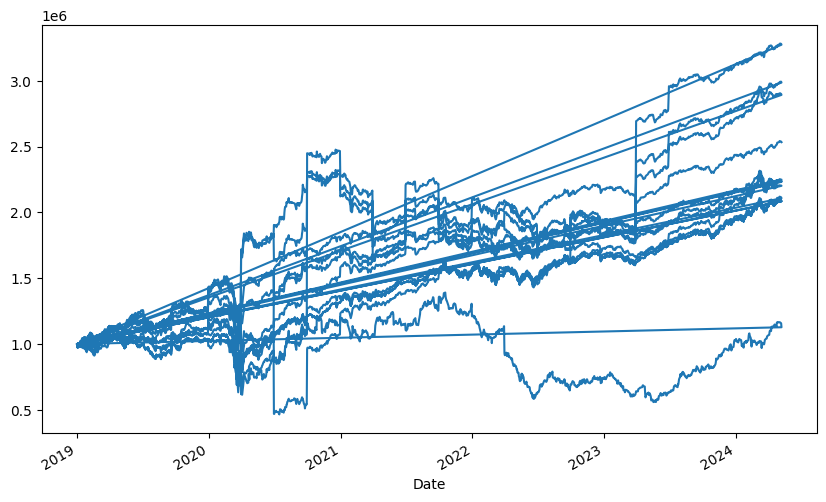

In [100]:
import matplotlib.pyplot as plt

# Assuming your time series data is stored in a variable called 'time_series'
plt.figure(figsize=(10, 6))
res11["Investment Value"].plot()

# Set the title and labels for the plot
# Show the plot
plt.savefig('Images/Backtest.png', format='png')
plt.show()



In [ ]:
res2 = res[["Expected Return", "Volatility", "Max Drawdown", "Sharpe Ratio", "Sortino Ratio", "Omega Ratio", "CAGR"]]
res2[["Expected Return", "Volatility", "Max Drawdown", "CAGR"]] = res2[["Expected Return", "Volatility", "Max Drawdown", "CAGR"]]*100
res_percent = res2.mean()[["Expected Return", "Volatility", "Max Drawdown", "Sharpe Ratio", "Sortino Ratio", "Omega Ratio", "CAGR"]]
print(res_percent.to_latex(float_format="%.2f%%"))
